# Deep Computer Vision: Contents of Project
- <a href='#1.0'>1. Exploring the Animals-10 Dataset</a>
    - <a href='#1.1'>1.1 Importing the Dataset</a>
    - <a href='#1.2'>1.2 Image Samples</a>
    - <a href='#1.3'>1.3 Image Dimensions</a>
    - <a href='#1.4'>1.4 Class Balance</a>
- <a href='#2.0'>2. Modeling</a>
    - <a href='#2.1'>2.1 tf.data Pipeline</a>
    - <a href='#2.2'>2.2 MobileNetV2 CNN Architecture</a>
        - <a href='#2.2.1'>2.2.1 Fine Tuning</a>
        - <a href='#2.2.2'>2.2.2 Evaluation & Predictions</a>
        - <a href='#2.2.3'>2.2.3 Save Model</a>
    

In [1]:
# Libraries
import numpy as np
import pandas as pd
import os
import re
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.utils import shuffle, class_weight

RANDOM_SEED = 42

# <a id="1.0">1. Exploring the Animals-10 Dataset</a>

## <a id="1.1">1.1 Importing the Dataset</a>

In [2]:
IMG_DIR = '../input/animals10/raw-img/'
img_folders = os.listdir(IMG_DIR)

In [3]:
# Translation dictionary
translate_dict={"cane":"Dog",
                "cavallo":"Horse",
                "elefante":"Elephant",
                "farfalla":"Butterfly",
                "gallina":"Chicken",
                "gatto":"Cat",
                "mucca":"Cow",
                "pecora":"Sheep",
                "ragno":"Spider",
                "scoiattolo":"Squirrel"
               }
# Class Names Dict
class_names_dict={'Butterfly':0,
                  'Cat':1,
                  'Chicken':2,
                  'Cow':3,
                  'Dog':4,
                  'Elephant':5,
                  'Horse':6,
                  'Sheep':7,
                  'Spider':8,
                  'Squirrel':9
                 }

In [4]:
# Pandas DataFrame containing the image paths and respective animal category
categories = []
categories_num = []
folders = []
files = []
extensions = []
extensionRegex = re.compile(r'\.[A-Za-z]+')
i = 0
for k, folder in enumerate(img_folders):
    filenames = os.listdir(IMG_DIR + folder)
    for file in filenames:
        files.append(IMG_DIR + folder + "/" + file)
        folders.append(folder)
        extensions.append(extensionRegex.search(file).group())
        for key in translate_dict.keys():
            Regex = re.compile(key)
            if type(Regex.search(folder)) != type(None):
                categories.append(translate_dict[key])
                categories_num.append(class_names_dict[translate_dict[key]])

df = pd.DataFrame({
    'filename'     : files,
    'extension'    : extensions,
    'folder'       : folders,
    'category'     : categories,
    'category_num' : np.array(categories_num, dtype=np.int16)
 })

In [5]:
df.head()

filename extension   folder  \
0  ../input/animals10/raw-img/cavallo/OIP-mdvOxIW...     .jpeg  cavallo   
1  ../input/animals10/raw-img/cavallo/OIP-TPYKs3X...     .jpeg  cavallo   
2  ../input/animals10/raw-img/cavallo/OIP-jlVRrok...     .jpeg  cavallo   
3  ../input/animals10/raw-img/cavallo/OIP-F4QVZ71...     .jpeg  cavallo   
4  ../input/animals10/raw-img/cavallo/OIP-UFtUZnX...     .jpeg  cavallo   

  category  category_num  
0    Horse             6  
1    Horse             6  
2    Horse             6  
3    Horse             6  
4    Horse             6

In [6]:
df.shape

(26179, 5)

In [7]:
# Check to see if there are any extensions which are not images
df.extension.value_counts()

.jpeg    24209
.jpg      1919
.png        51
Name: extension, dtype: int64

Extensions are good.

## <a id="1.2">1.2 Image Samples</a>

In [8]:
def sample_images_data(data, category_col, sample_per_cat):
    # An empty list to collect some samples
    sample_images = []
    sample_labels = []

    df_shuffled = shuffle(data, random_state=RANDOM_SEED)
    
    # Iterate over the keys of the labels dictionary defined in the above cell
    for k in list(data[category_col].value_counts().index):
        # Get four samples for each category
        samples = df_shuffled[df_shuffled[category_col] == k].head(sample_per_cat)
        # Append the samples to the samples list
        for j, s in enumerate(samples.values):
            # First column contain labels, hence index should start from 1
            img = np.array(samples.iloc[j, 0])
            sample_images.append(img)
            sample_labels.append(samples.iloc[j, 3])
    
    del df_shuffled
    print("Total number of sample images to plot: ", len(sample_images))
    return sample_images, sample_labels

In [9]:
img_samples, img_samples_labels = sample_images_data(df, 'category', 5)

Total number of sample images to plot:  50


In [10]:
def plot_sample_images(data_sample_images,data_sample_labels):
    f, ax = plt.subplots(10,5,figsize=(32,20))
    for i in range(0,len(data_sample_images)):
        img = plt.imread(str(data_sample_images[i]))
        plt.subplot(10,5, i+1)
        plt.title(data_sample_labels[i])
        plt.axis('off')
        plt.imshow(img)
    plt.show()

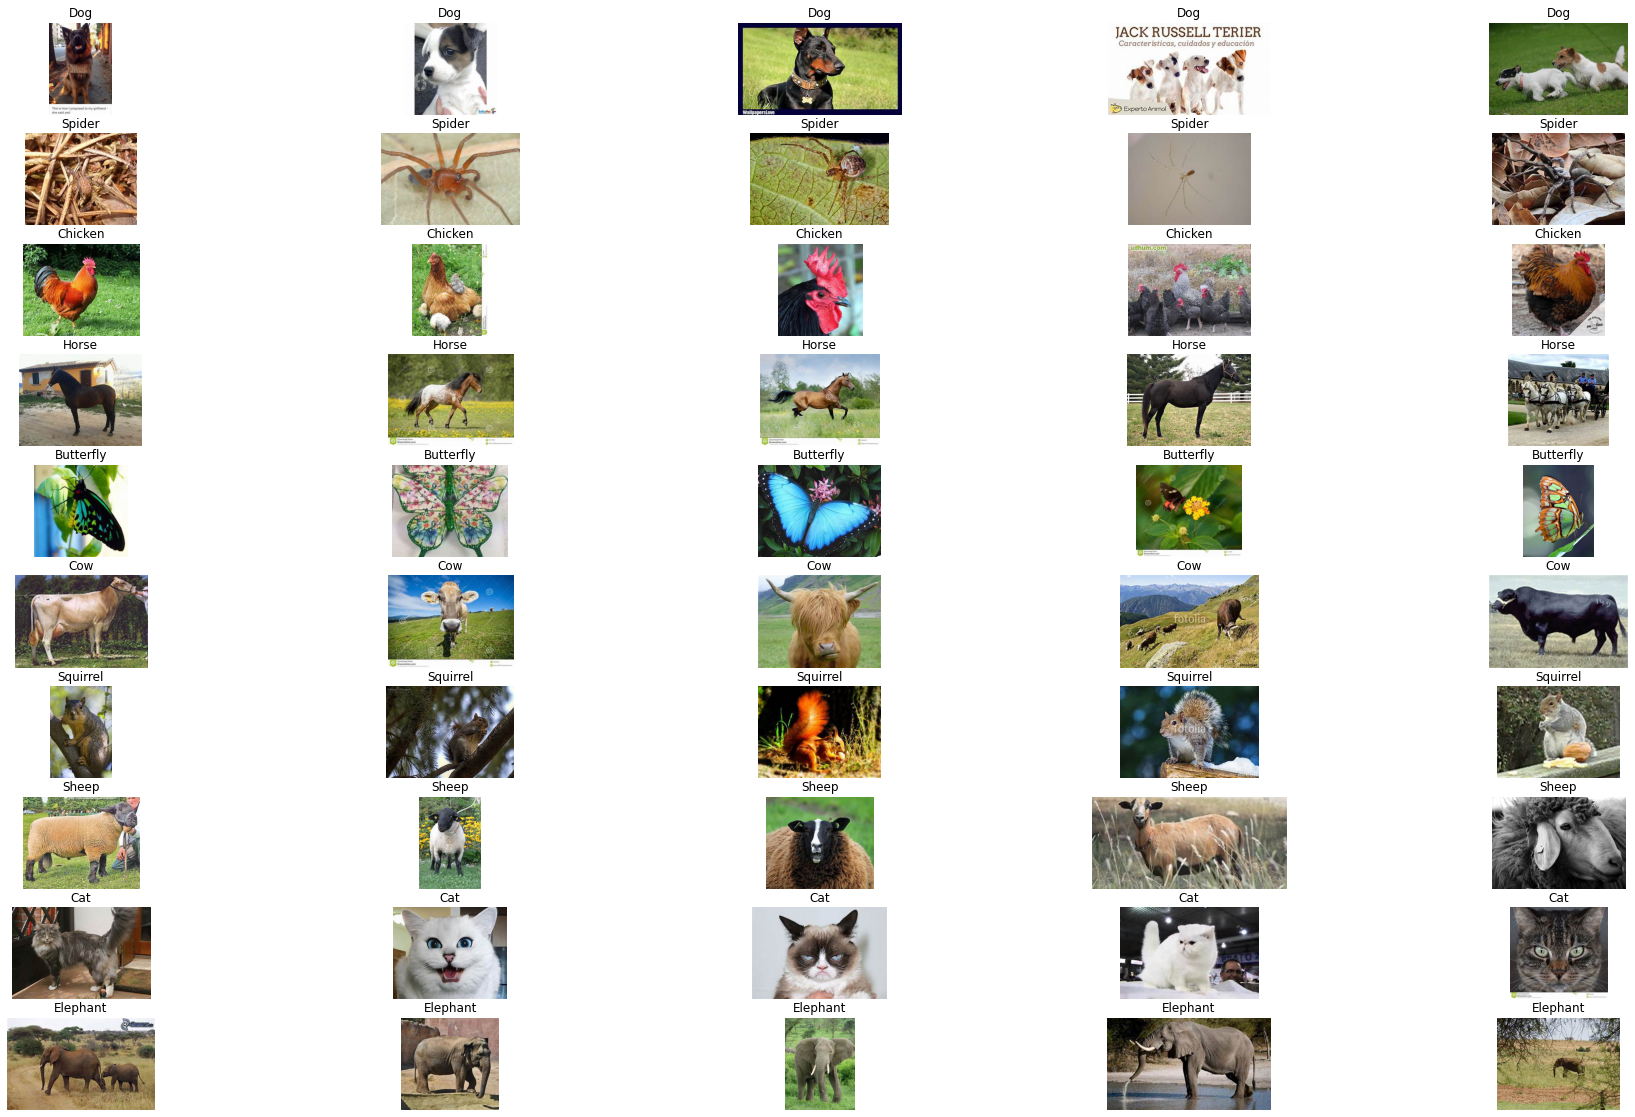

In [11]:
plot_sample_images(img_samples, img_samples_labels)

## <a id="1.3">1.3 Image Dimensions</a>

In [12]:
# Image Dimensions
def max_min_dimensions(data, category_col):
    for category in list(data[category_col].value_counts().index):
        dim_y = []
        dim_x = []
        for file in list(data.loc[data[category_col]==category]['filename']):
            dim_y.append(plt.imread(file).shape[0])
            dim_x.append(plt.imread(file).shape[1])
        print("{:<20s}:   Min Height: {:,} Min Width: {:,} Max Height: {:,} Max Width: {:,}".format(category,min(dim_y),min(dim_x),max(dim_y),max(dim_x)))

In [13]:
max_min_dimensions(df.sample(n=1000), 'category')

Spider              :   Min Height: 150 Min Width: 138 Max Height: 640 Max Width: 640
Dog                 :   Min Height: 155 Min Width: 169 Max Height: 300 Max Width: 300
Chicken             :   Min Height: 125 Min Width: 169 Max Height: 300 Max Width: 300
Horse               :   Min Height: 157 Min Width: 169 Max Height: 300 Max Width: 300
Squirrel            :   Min Height: 157 Min Width: 186 Max Height: 300 Max Width: 300
Cow                 :   Min Height: 119 Min Width: 192 Max Height: 300 Max Width: 300
Butterfly           :   Min Height: 111 Min Width: 102 Max Height: 640 Max Width: 640
Elephant            :   Min Height: 125 Min Width: 200 Max Height: 640 Max Width: 640
Sheep               :   Min Height: 169 Min Width: 169 Max Height: 640 Max Width: 640
Cat                 :   Min Height: 90 Min Width: 120 Max Height: 5,365 Max Width: 4,928


**Images are of varying dimensions. For pre-trained CNN, these images will need to be pre-processed to a defined height and width.**

## <a id="1.4">1.4 Class Balance</a>

In [14]:
# Animal Category Frequencies
def plot_count_per_class(data, class_labels):
    f, ax = plt.subplots(1,1, figsize=(12,4))
    g = sns.countplot(x = data[class_labels])
    g.set_title("Number of items for each class")
    g.set_xlabel("Category")
    
    plt.show()  

def get_count_per_class(data, class_labels):
    # Get the count for each label
    label_counts = data[class_labels].value_counts()

    # Get total number of samples
    total_samples = len(data[class_labels])


    # Count the number of items in each class
    for i in range(len(label_counts)):
        label = label_counts.index[i]
        count = label_counts.values[i]
        percent = (count / total_samples) * 100
        print("{:<20s}:   {:,} or {:.1f}%".format(label, count, percent))

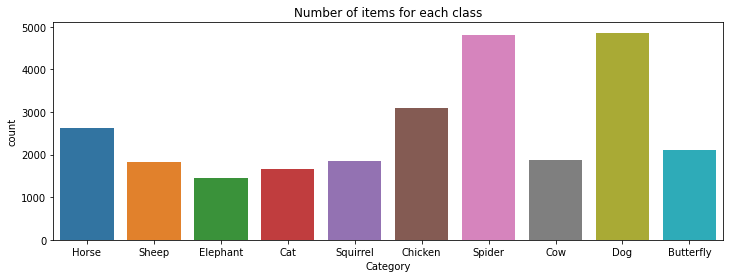

Dog                 :   4,863 or 18.6%
Spider              :   4,821 or 18.4%
Chicken             :   3,098 or 11.8%
Horse               :   2,623 or 10.0%
Butterfly           :   2,112 or 8.1%
Cow                 :   1,866 or 7.1%
Squirrel            :   1,862 or 7.1%
Sheep               :   1,820 or 7.0%
Cat                 :   1,668 or 6.4%
Elephant            :   1,446 or 5.5%


In [15]:
plot_count_per_class(df, 'category')
get_count_per_class(df, 'category')

**Dataset is imbalanced concerning category class.**

I can do either of the following:
1. Keep the class imbalance as it is and use Area-under-the-Curve (AUC) to evaluate the model. Upside: No additional preprocessing to the data required (other than the preprocessing needed for the modelling). Downside: AUC metric can be difficult to explain to non-technical audience (not as simple as accuracy).
2. Sample the dataset so that no class imbalance exists (all classes are have same frequency). Upside: accuracy metric can be used to evalauate model. Downside: not all data used for training purposes and therefore model might not generalize well on new data.
3. Keep the class imbalance as it is and specify a class weight dictionary for the model. Upside: accuracy metric can be used to evalauate model and all data can be used to train model. This method keeps the upside of method 1, plus it retains the accuracy metric (easier to explain to non-technical audience).

Method 3 is what I shall employ.

In [16]:
# Class Weight Dictionary
keys   = np.unique(df['category_num'], return_counts=True)[0]
values = class_weight.compute_class_weight(class_weight='balanced',
                                           classes=keys,
                                           y=df['category_num'])
class_weights_dict = dict(zip(keys,values))
class_weights_dict

{0: 1.2395359848484848,
 1: 1.569484412470024,
 2: 0.8450290510006456,
 3: 1.4029474812433012,
 4: 0.5383302488176023,
 5: 1.8104426002766252,
 6: 0.9980556614563477,
 7: 1.4384065934065935,
 8: 0.5430201203069902,
 9: 1.4059613319011814}

# <a id="2.0">2. Modeling</a>

For memory purposes, it is better to read the images "off-disk" rather than store them in memory. A tf.data Pipeline will assist with this.

## <a id="2.1">2.1 tf.data Pipeline</a>

In [17]:
BATCH_SIZE = 32
IMG_HEIGHT = 150
IMG_WIDTH  = 150
CHANNELS   = 3
IMG_SIZE   = (IMG_HEIGHT, IMG_WIDTH)

In [18]:
# Training Dataset
train_ds = keras.preprocessing.image_dataset_from_directory(
    IMG_DIR,
    validation_split=0.2,
    subset="training",
    seed=RANDOM_SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

# Validation Dataset
val_ds = keras.preprocessing.image_dataset_from_directory(
    IMG_DIR,
    validation_split=0.2,
    subset="validation",
    seed=RANDOM_SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,)

Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.


In [19]:
# Test Dataset (20% of Validation Dataset)
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [20]:
# Autotune Datasets
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [21]:
# Data Augmentation
data_augmentation = keras.Sequential([
  keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

## <a id="2.2">2.2 MobileNetV2 CNN Architecture</a>

MbileNetV2 is an improved CNN architecture over MobileNet, with fewer parameters.

In [22]:
preprocess_input = keras.applications.mobilenet_v2.preprocess_input

# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='../input/tf-keras-pretrained-model-weights/No Top/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_192_no_top.h5')

image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)

base_model.trainable = False

global_average_layer = keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

prediction_layer = keras.layers.Dense(10, activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)

In [23]:
inputs = keras.Input(shape=IMG_SIZE+(3,))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = keras.Model(inputs, outputs)

In [24]:
base_learning_rate = 0.0001
model.compile(optimizer=keras.optimizers.Adam(lr=base_learning_rate),
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 150, 150, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 150, 150, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_150 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [26]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("mobilenetv2_nn.h5",
                                                save_best_only=True
                                               )
EPOCHS = 5
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds,
                    class_weight=class_weights_dict,
                    callbacks=[checkpoint_cb]
)
# Roll back to best model
model = keras.models.load_model("mobilenetv2_nn.h5")

Epoch 1/5
655/655 [==============================] - 321s 486ms/step - loss: 2.0987 - accuracy: 0.4018 - val_loss: 0.5005 - val_accuracy: 0.8597
Epoch 2/5
655/655 [==============================] - 296s 452ms/step - loss: 0.8400 - accuracy: 0.7622 - val_loss: 0.3364 - val_accuracy: 0.9074
Epoch 3/5
655/655 [==============================] - 296s 451ms/step - loss: 0.6482 - accuracy: 0.8191 - val_loss: 0.2900 - val_accuracy: 0.9178
Epoch 4/5
655/655 [==============================] - 295s 450ms/step - loss: 0.5901 - accuracy: 0.8309 - val_loss: 0.2646 - val_accuracy: 0.9221
Epoch 5/5
655/655 [==============================] - 294s 448ms/step - loss: 0.5311 - accuracy: 0.8491 - val_loss: 0.2513 - val_accuracy: 0.9240


In [27]:
def plot_learning_curves(history_class):
    acc = history_class.history['accuracy']
    val_acc = history_class.history['val_accuracy']

    loss = history_class.history['loss']
    val_loss = history_class.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

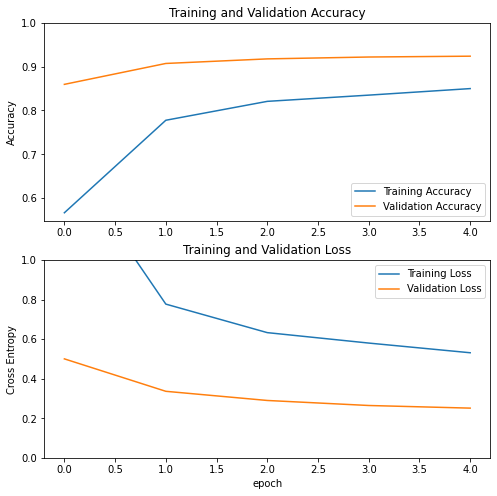

In [28]:
plot_learning_curves(history)

### <a id="2.2.1">2.2.1 Fine Tuning</a>

In [29]:
base_model.trainable = True

# Number of layers in base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [30]:
# Fine-tune from this layer onwards
fine_tune_at = 144

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [31]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 150, 150, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 150, 150, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_150 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [33]:
FINE_TUNE_EPOCHS = 5
TOTAL_EPOCHS =  EPOCHS + FINE_TUNE_EPOCHS

history_fine = model.fit(train_ds,
                         epochs=TOTAL_EPOCHS,
                         initial_epoch=history.epoch[-1], #Best original epoch no 4 (val_accuracy = 0.92)
                         validation_data=val_ds,
                         class_weight=class_weights_dict,
                         callbacks=[checkpoint_cb]
)
model = keras.models.load_model("mobilenetv2_nn.h5")

Epoch 5/10
655/655 [==============================] - 297s 450ms/step - loss: 0.5105 - accuracy: 0.8557 - val_loss: 0.2476 - val_accuracy: 0.9276
Epoch 6/10
655/655 [==============================] - 293s 447ms/step - loss: 0.5170 - accuracy: 0.8558 - val_loss: 0.2430 - val_accuracy: 0.9295
Epoch 7/10
655/655 [==============================] - 293s 447ms/step - loss: 0.5011 - accuracy: 0.8618 - val_loss: 0.2419 - val_accuracy: 0.9288
Epoch 8/10
655/655 [==============================] - 294s 448ms/step - loss: 0.4939 - accuracy: 0.8593 - val_loss: 0.2426 - val_accuracy: 0.9285
Epoch 9/10
655/655 [==============================] - 295s 449ms/step - loss: 0.4988 - accuracy: 0.8571 - val_loss: 0.2385 - val_accuracy: 0.9299
Epoch 10/10
655/655 [==============================] - 293s 447ms/step - loss: 0.4993 - accuracy: 0.8596 - val_loss: 0.2375 - val_accuracy: 0.9307


In [34]:
def plot_fine_tune_curves(history_class, ft_history_class, initial_epochs):
    acc = history_class.history['accuracy']
    val_acc = history_class.history['val_accuracy']

    loss = history_class.history['loss']
    val_loss = history_class.history['val_loss']
    
    acc += ft_history_class.history['accuracy']
    val_acc += ft_history_class.history['val_accuracy']

    loss += ft_history_class.history['loss']
    val_loss += ft_history_class.history['val_loss']
    
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.ylim([0.7, 1])
    plt.plot([initial_epochs-1,initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.ylim([0, 1.0])
    plt.plot([initial_epochs-1,initial_epochs-1],
             plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

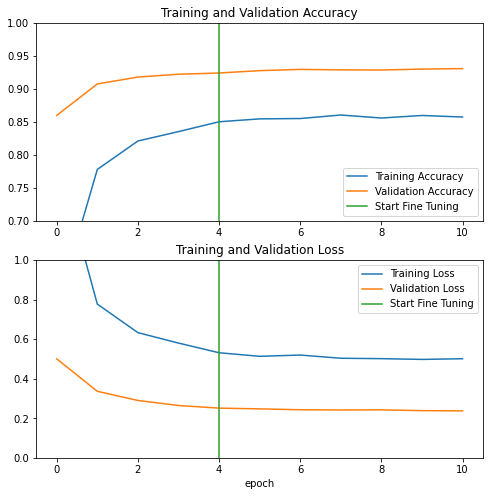

In [35]:
plot_fine_tune_curves(history, history_fine, EPOCHS)

### <a id="2.2.2">2.2.2 Evaluation & Predictions</a>

In [36]:
loss, accuracy = model.evaluate(test_ds)
print(f'Test accuracy :{accuracy*100:.1f}%')

32/32 [==============================] - 12s 335ms/step - loss: 0.2033 - accuracy: 0.9365
Test accuracy :93.7%


In [37]:
class_names = dict(zip(class_names_dict.values(),translate_dict.values()))

In [38]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = np.argmax(model.predict_on_batch(image_batch), axis=1)

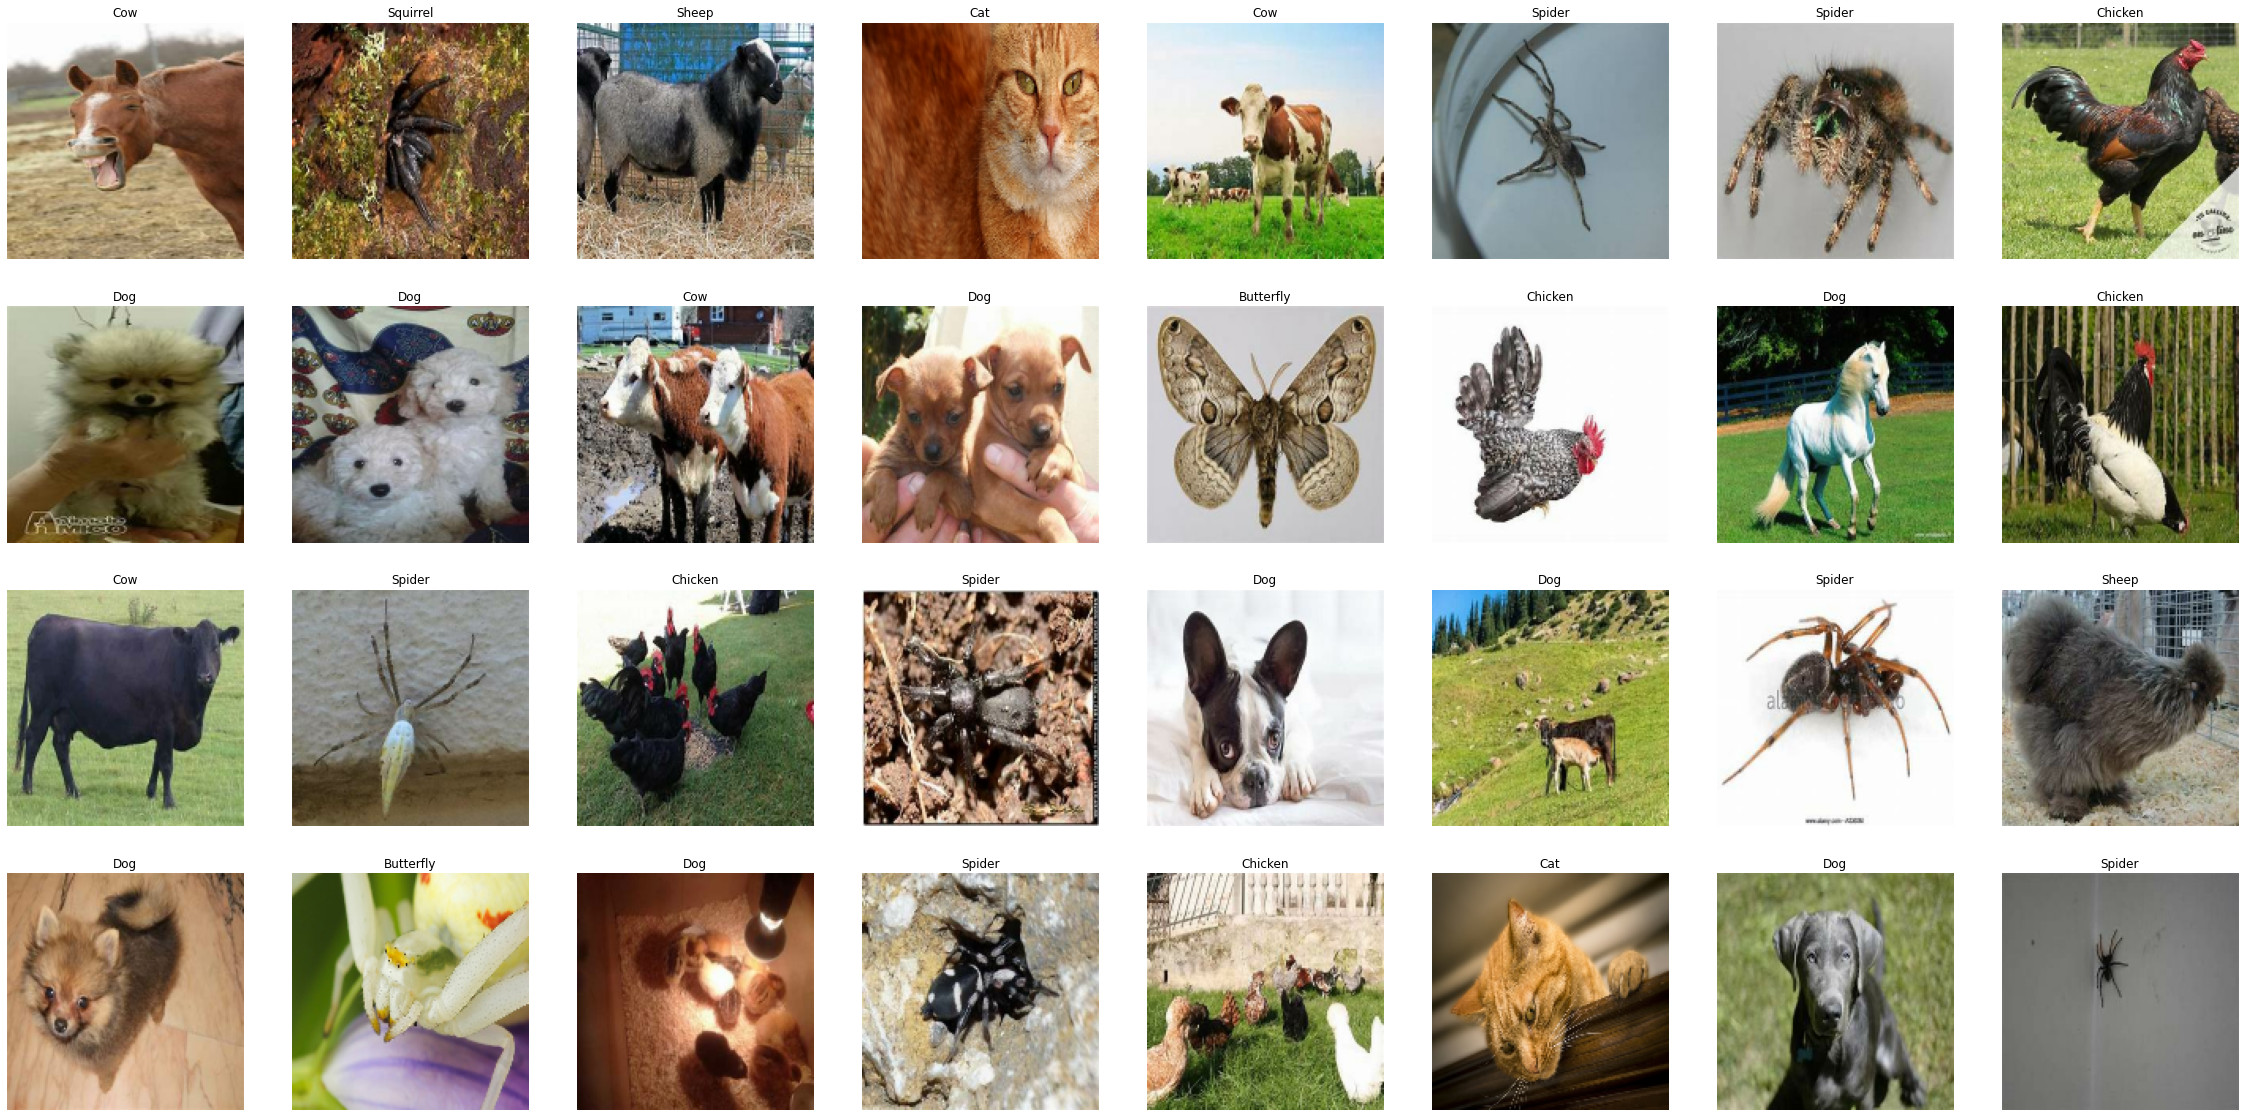

In [39]:
plt.figure(figsize=(40, 20))
for i in range(BATCH_SIZE):
    ax = plt.subplot(4, 8, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")

### <a id="2.2.3">2.2.3 Save Model</a>

In [40]:
model.save("final_mobilenetv2_nn.h5")

# Acknowledgements

* Preda, G. CNN with Tensorflow|Keras for Fashion MNIST. Kaggle.com. https://www.kaggle.com/gpreda/cnn-with-tensorflow-keras-for-fashion-mnist.
* min4tozaki. animal classification Kaggle.com. https://www.kaggle.com/min4tozaki/animal-classification